In [1]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd
import cv2

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import matplotlib.pyplot as plt 
%matplotlib inline

import newscripts as myutils

Using TensorFlow backend.


In [17]:
def pltPathologyClusters(labels, path):
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    fig = plt.figure(figsize=(14, 14))
    
    x=1
    
    for cluster in sub_directories:
        direct = path + '/{}'.format(cluster)
        if len(os.listdir(direct))-9 > 9: # if directory has less than 9 images set index to 0 else random index
            index = np.random.randint(9,len(os.listdir(direct))-9)
        else:
            index = 0 # pick the first 10 images
        clusterList = [] # reset the row
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                image = tifffile.imread(os.path.join(path, file))
                clusterList.append(image)
                displayImages.append(image) # list of ALL Images
                
        for i in range(1,9+1):
            if (len(clusterList) > i):
                img = clusterList[i-1]
            fig.add_subplot(8, 9, x)
            plt.imshow(img)
            plt.axis('off')
            plt.subplots_adjust(wspace=0.0, hspace=0.0)
            x+=1
    
    plt.show()
    

In [2]:
import shutil

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)
    
def clusterintoDirectories(labels, path, imagenamesList):
    # remove existing subdirectories first to avoid overlap
    sub_directories = [str(i) for i in range(8)]

    for cluster in sub_directories:
        if (cluster in os.listdir(path)) and (os.path.isdir(os.path.join(path , cluster))):
            shutil.rmtree(os.path.join(path , cluster))

    for filename in os.listdir(path):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(path + '/{}'.format(cluster) , exist_ok=True)
    
    
    for i in range(len(imagenamesList)):
        # if there isnt already a symlink of this image in the coressponding subdirectory
        if imagenamesList[i] not in os.listdir(path + '/' + sub_directories[labels[i]]): 
            symlink_rel(path + '/{}'.format(imagenamesList[i]) , 
                       path + '/{}'.format(labels[i]) + '/' + imagenamesList[i])

In [3]:
# Load training data

train_directory = "../../Data/Kather_all_train"

X_train = []
train_image_names = []

for filename in os.listdir(train_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(train_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (144, 144)) 
        X_train.append(np.asarray( resized_image, dtype="uint8" ))
        train_image_names.append(filename)

y_train = myutils.loadLabelsFromsubdirectoryindex(train_image_names, "../../Data/Kather_original_train")

# Load testing data

test_directory = "../../Data/Kather_all_test"

X_test = []
test_image_names = []

for filename in os.listdir(test_directory):
    if filename.endswith('tif'):
        image = cv2.imread(os.path.join(test_directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (144, 144)) 
        X_test.append(np.asarray( resized_image, dtype="uint8" ))
        test_image_names.append(filename)

y_test = myutils.loadLabelsFromsubdirectoryindex(test_image_names, "../../Data/Kather_original_test")

In [4]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

# Normalise
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [5]:
autoencoder = load_model('../Autoencoders/SavedModels/weights/finalists/CAER_MSE_KATHER.h5', compile=False) # 6 x 6 x 16
autoencoder.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 144, 144, 3)  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 144, 144, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_52 (LeakyReLU)      (None, 144, 144, 16) 0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 144, 144, 32) 4640        leaky_re_lu_52[0][0]             
____________________________________________________________________________________________

In [7]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv2d_43').output)

In [10]:
X_train_enc = encoder.predict(X_train)
print(X_train_enc.shape)

X_test_enc = encoder.predict(X_test)
print(X_test_enc.shape)

X_train_enc = X_train_enc.reshape(X_train_enc.shape[0] , -1) # Reshape for scaling
X_train_enc = StandardScaler().fit_transform(X_train_enc) # Scale

X_test_enc = X_test_enc.reshape(X_test_enc.shape[0] , -1) # Reshape for scaling
X_test_enc = StandardScaler().fit_transform(X_test_enc) # Scale

# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(X_train_enc, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(X_train_enc, y_train)
print(clf2.best_estimator_)
clf2.best_score_

(4200, 9, 9, 32)
(800, 9, 9, 32)
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.7193166927292138
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)


0.5545186268787916

In [11]:
# best estimator
gmm_best = clf.best_estimator_.fit(X_train_enc)
gmm_labels = gmm_best.predict(X_test_enc)

print(metrics.completeness_score(y_test , gmm_labels))

# best estimator

k_best = clf2.best_estimator_.fit(X_train_enc)
k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test , k_labels))

0.7808239334063241
0.5798134617064069


In [14]:
gmm_labels_train = gmm_best.predict(X_train_enc)

print(metrics.completeness_score(y_train , gmm_labels_train))


0.5457346704643359


In [22]:
k_labels = k_best.predict(X_train_enc)
print(metrics.completeness_score(y_trainn , k_labels))

0.5490782730436172


In [13]:
print(len(set(gmm_labels)))

6


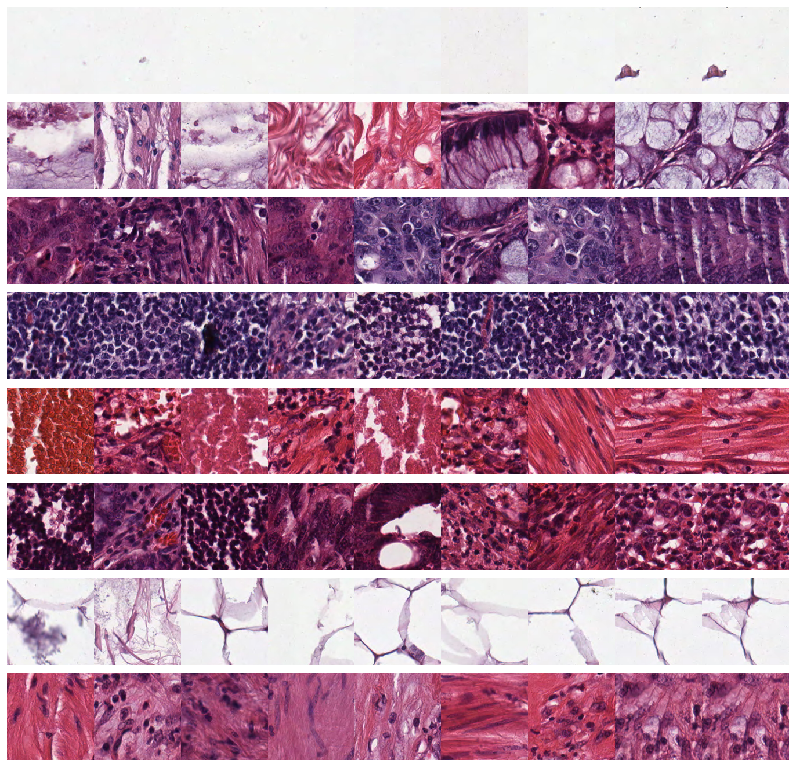

In [19]:
clusterintoDirectories(gmm_labels_train, train_directory, train_image_names)
pltPathologyClusters(gmm_labels_train, train_directory)

In [20]:
pca1 = PCA(n_components=220)
transformed_train = pca1.fit_transform(X_train_enc)

pca2 = PCA(n_components=220)
transformed_test = pca2.fit_transform(X_test_enc)

print(sum(pca1.explained_variance_ratio_))
print(sum(pca2.explained_variance_ratio_))
# print(pca1.n_components_)
# pca2.n_components_

0.9498748378828168
0.9679783159808721


In [21]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(transformed_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(transformed_train, y_train)
print(clf2.best_estimator_)
clf2.best_score_

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.5878680659247866
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)


0.5548123818741045

In [24]:
# best estimator
gmm_best = clf.best_estimator_.fit(X_train_enc)
gmm_labels = gmm_best.predict(X_test_enc)
print(len(set(gmm_labels)))
print(metrics.completeness_score(y_test , gmm_labels))
gmm_labels_train = gmm_best.predict(X_train_enc)
print(metrics.completeness_score(y_train, gmm_labels_train))

# best estimator

k_best = clf2.best_estimator_.fit(X_train_enc)
k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test , k_labels))
k_labels_train = k_best.predict(X_train_enc)
print(metrics.completeness_score(y_train, k_labels_train))

6
0.7790868322800409
0.5487690884513694
0.5798134617064069
0.5490782730436172


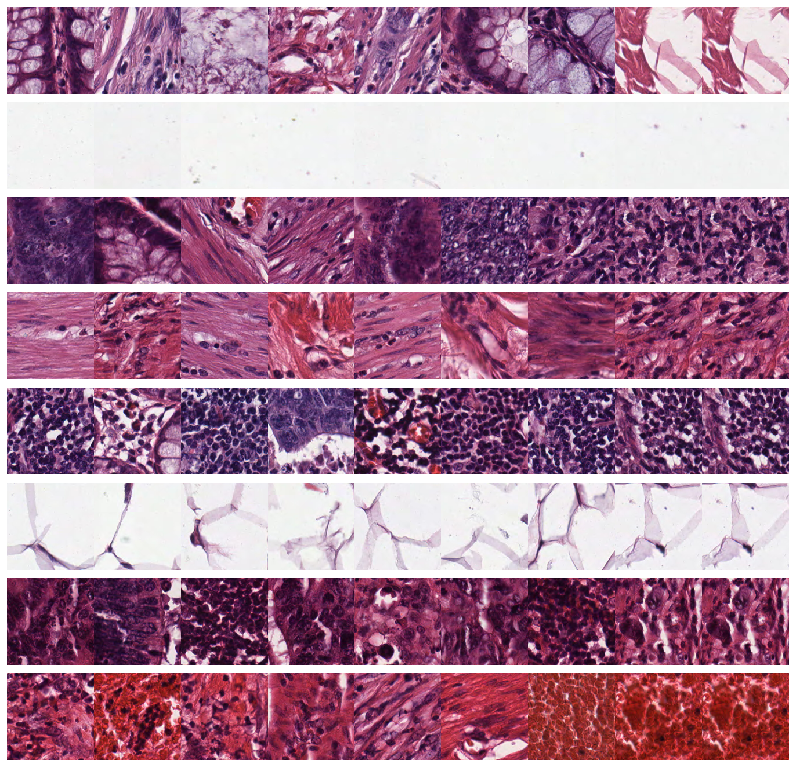

In [25]:
clusterintoDirectories(k_labels, test_directory, test_image_names)
pltPathologyClusters(k_labels, test_directory)

In [26]:
autoencoder = load_model('../Autoencoders/SavedModels/weights/finalists/CAER_SSIM_Kather.h5', compile=False) # 6 x 6 x 16
autoencoder.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 144, 144, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 144, 144, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 144, 144, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 144, 144, 32) 4640        leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [27]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv2d_7').output)

In [28]:
X_train_enc = encoder.predict(X_train)
print(X_train_enc.shape)

X_test_enc = encoder.predict(X_test)
print(X_test_enc.shape)

X_train_enc = X_train_enc.reshape(X_train_enc.shape[0] , -1) # Reshape for scaling
X_train_enc = StandardScaler().fit_transform(X_train_enc) # Scale

X_test_enc = X_test_enc.reshape(X_test_enc.shape[0] , -1) # Reshape for scaling
X_test_enc = StandardScaler().fit_transform(X_test_enc) # Scale

# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(X_train_enc, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(X_train_enc, y_train)
print(clf2.best_estimator_)
clf2.best_score_

(4200, 9, 9, 32)
(800, 9, 9, 32)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

  FitFailedWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrease the number of components, or increase reg_covar.

  FitFailedWarni

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=19, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.5160463244866719
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)


0.5010025604308012

In [34]:
# best estimator
gmm_best = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=19, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(X_train_enc)
gmm_labels = gmm_best.predict(X_test_enc)
print(len(set(gmm_labels)))
print(metrics.completeness_score(y_test , gmm_labels))
gmm_labels_train = gmm_best.predict(X_train_enc)
print(metrics.completeness_score(y_train, gmm_labels_train))

# best estimator

k_best = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0).fit(X_train_enc)
k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test , k_labels))
k_labels_train = k_best.predict(X_train_enc)
print(metrics.completeness_score(y_train, k_labels_train))

8
0.5615460323706372
0.5265193465172266
0.49958452327518416
0.49195387767994997


In [31]:
pca1 = PCA(n_components=30)
transformed_train = pca1.fit_transform(X_train_enc)

pca2 = PCA(n_components=30)
transformed_test = pca2.fit_transform(X_test_enc)

print(sum(pca1.explained_variance_ratio_))
print(sum(pca2.explained_variance_ratio_))
# print(pca1.n_components_)
# pca2.n_components_

0.9595280047506094
0.9613868260057643


In [32]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(transformed_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(transformed_train, y_train)
print(clf2.best_estimator_)
clf2.best_score_

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.5320230204086615
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


0.501548325135572

In [33]:
# best estimator
gmm_best = clf.best_estimator_.fit(X_train_enc)
gmm_labels = gmm_best.predict(X_test_enc)
print(len(set(gmm_labels)))
print(metrics.completeness_score(y_test , gmm_labels))
gmm_labels_train = gmm_best.predict(X_train_enc)
print(metrics.completeness_score(y_train, gmm_labels_train))

# best estimator

k_best = clf2.best_estimator_.fit(X_train_enc)
k_labels = k_best.predict(X_test_enc)
print(metrics.completeness_score(y_test , k_labels))
k_labels_train = k_best.predict(X_train_enc)
print(metrics.completeness_score(y_train, k_labels_train))

8
0.5180438257085295
0.49516013628423783
0.499584523275184
0.4921221903322008


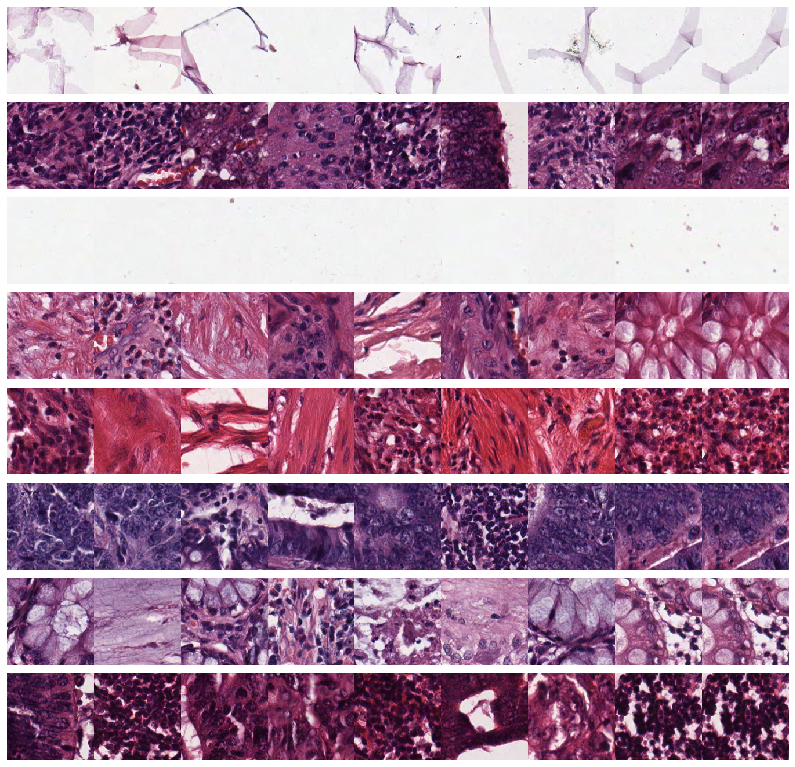

In [35]:
clusterintoDirectories(gmm_labels, test_directory, test_image_names)
pltPathologyClusters(gmm_labels, test_directory)

In [37]:
def plotdiffTsne_kmeans(X,estimator):
    fig, axs = plt.subplots(1, 1, figsize=(13, 7))

    tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(X)
    kmeans2 = estimator.fit(tsne2)
     
    axs[0, 1].scatter(tsne2[:, 0], tsne2[:, 1], c=kmeans2.labels_, cmap='viridis')
    axs[0, 1].set_title('TSNE perplexity = 30')


    tsne4 = TSNE(n_components=2, perplexity = 90).fit_transform(X)
    kmeans4 = estimator.fit(tsne4)

    axs[1, 1].scatter(tsne4[:, 0], tsne4[:, 1], c=kmeans4.labels_, cmap='viridis')
    axs[1, 1].set_title('TSNE perplexity = 90')
    
    plt.savefig('TSNE-CAE.png')
    plt.show()

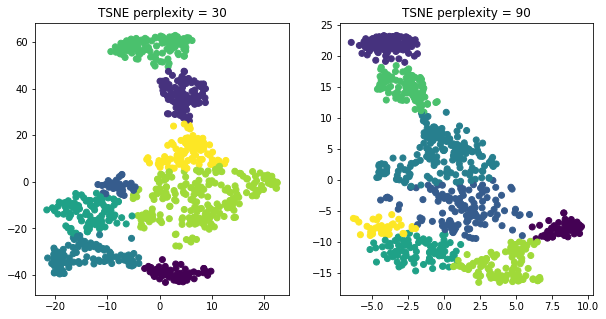

In [55]:
est = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(transformed_test)
gmm1 = est.fit(tsne2)
gmm1_labels = gmm1.predict(tsne2)

axs[0].scatter(tsne2[:, 0], tsne2[:, 1], c=gmm1_labels, cmap='viridis')
axs[0].set_title('TSNE perplexity = 30')


tsne4 = TSNE(n_components=2, perplexity = 90).fit_transform(transformed_test)
gmm2 = est.fit(tsne4)
labels2 = gmm2.predict(tsne4)

axs[1].scatter(tsne4[:, 0], tsne4[:, 1], c=labels2, cmap='viridis')
axs[1].set_title('TSNE perplexity = 90')

plt.savefig('TSNE-final-2.png')
plt.show()

In [38]:
def plotdiffTsne_gmm(X,estimator):
    fig, axs = plt.subplots(2, 2, figsize=(13, 7))

    tsne2 = TSNE(n_components=2, perplexity = 30).fit_transform(X)
    gmm = estimator.fit(tsne2)
    labels = gmm.predict(tsne2)
    
    axs[0, 1].scatter(tsne2[:, 0], tsne2[:, 1], c=labels, cmap='viridis')
    axs[0, 1].set_title('TSNE perplexity = 30')


    tsne4 = TSNE(n_components=2, perplexity = 90).fit_transform(X)
    kmeans4 = estimator.fit(tsne4)
    labels2 = kmeans4.predict(tsne4)
    
    axs[1, 1].scatter(tsne4[:, 0], tsne4[:, 1], c=labels2, cmap='viridis')
    axs[1, 1].set_title('TSNE perplexity = 90')
    
    plt.savefig('TSNE-CAE.png')
    plt.show()

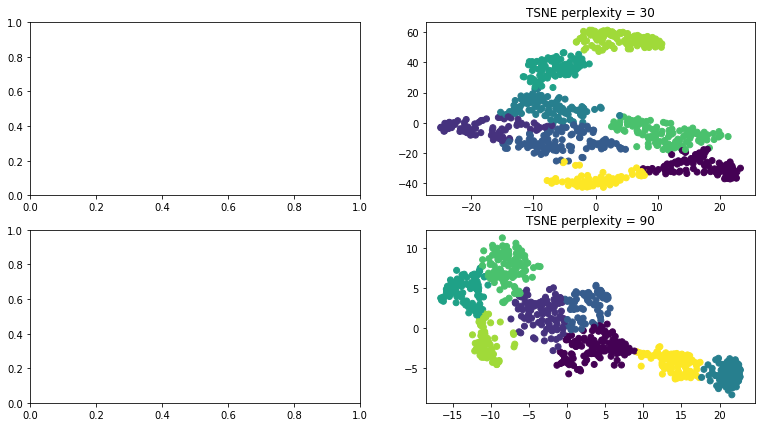

In [39]:
est = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

plotdiffTsne_kmeans(transformed_test,est)

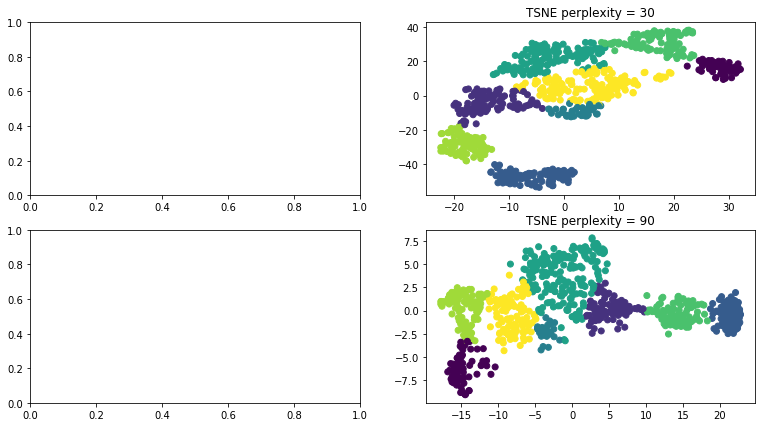

In [40]:
est = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

plotdiffTsne_gmm(transformed_test,est)

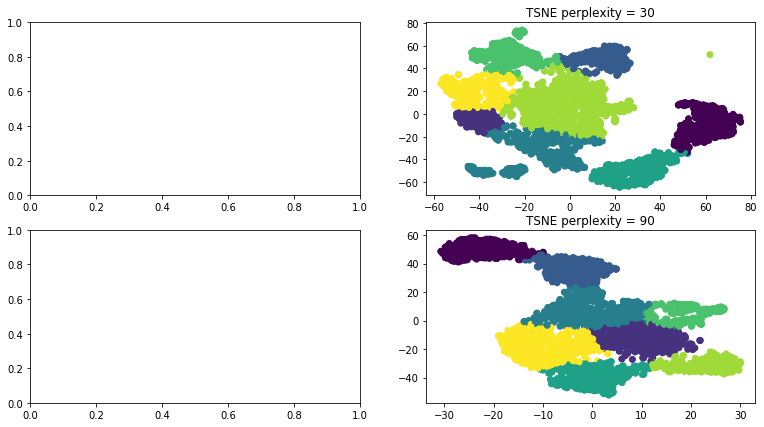

In [41]:
plotdiffTsne_gmm(transformed_train ,est)